In [1]:
from cloudmesh.common.Shell import Shell
from cloudmesh.common.util import readfile
import sys
import pandas as pd
import io
import seaborn as sns
import matplotlib.pyplot as plt
import os
from pathlib import Path
import glob
from pprint import pprint
from cloudmesh.common.dotdict import dotdict
import numpy as np

# This notebook creates shaded line plots of power draw (W) over time (s).

If you get an error when running this notebook, please update numpy.
`pip install numpy -U`

Additionally, ensure that you have downloaded the data by using `make fetch`. This fetch command does not work on Windows, so run it in WSL.

In [2]:
# list_of_dirs = [
#     ('./data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_2', 2),
#     ('./data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_30', 30),
#     ('./data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_70', 70)]

list_of_dirs = [('./data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_2', 2),
                     ('./data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_30', 30),
                     ('./data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_70', 70),
                     ('./data/card_name_v100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_25', 25),
                     ('./data/card_name_v100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_29', 29),
                     ('./data/card_name_v100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_33', 33),
                     ('./data/card_name_v100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_35', 35)]
                     # ('./data/card_name_k80_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_25', 25)
                     # ('./data/card_name_k80_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_29', 29),
                     # ('./data/card_name_k80_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_33', 33),
                     # ('./data/card_name_k80_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_35', 35)]


In [3]:
files = []
for directory, epoch in list_of_dirs:
    gpulog = os.path.join(Path(directory), "gpu0.log")
    eventlog = glob.glob(f"{directory}/*.err")[0]
    files.append(dotdict(
        {
            "epoch" : epoch,
            "eventlog": eventlog,
            "gpulog": gpulog
        })
    )

pprint (files)

[{'epoch': 2,
  'eventlog': './data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_2\\dje5dj-45737981.err',
  'gpulog': 'data\\card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_2\\gpu0.log'},
 {'epoch': 30,
  'eventlog': './data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_30\\dje5dj-45737982.err',
  'gpulog': 'data\\card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_30\\gpu0.log'},
 {'epoch': 70,
  'eventlog': './data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_70\\dje5dj-45737983.err',
  'gpulog': 'data\\card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_70\\gpu0.log'},
 {'epoch': 25,
  'eventlog': './data/card_name_v100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_25\\dje5dj-45330311.err',
  'gpulog': 'data\\card_name_v100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_25\\gpu0.log'},
 {'

In [4]:
def convert_column_to_seconds(df, col):
    # df[[name]] = df[[name]].astype('datetime64[us]')
    df[col] = pd.to_datetime(df[col], errors='coerce')
    # df[[name]] = pd.to_datetime(df[[name]], errors='coerce')
    start_t = df[col].iloc[0]
    print (start_t, type(start_t))
    for index, row in df.iterrows():

        delta = df.loc[index, col] - start_t
        df.loc[index, col] = delta.total_seconds()
    # df[name_of_seconds_column] = df[name] - start_t
    # df[[name]] = df[[name]].astype(int)/1000000000
    return df

def fix_date_format(df, col):
    # if We have T in it, we do not need to fix
    for i, row in df.iterrows():
        value = df.loc[i,col]
        if "T" not in value:
            new_date = df.loc[i,col].replace(":", " ", 1)
            df.loc[i,col] = new_date
    df[col] = pd.to_datetime(df[col])
    return df

In [5]:
def read_energy(filename=None):
    location = Shell.map_filename(filename).path
    # 1: means removing hashes
    content = readfile(location).splitlines()[1:]
    # removing #
    content[0] = content[0][2:]
    # print(content[0:10])
    content = "\n".join(content)
    content = content.replace(', ', ',')
    df = pd.read_csv(io.StringIO(content),sep=',')

    df = fix_date_format(df, "time")
    df[["time"]] = df[["time"]].astype('datetime64[ns]')
    return df


In [6]:
def read_eventlog(filename):
    location = Shell.map_filename(filename).path
    content = readfile(location, encoding='utf-8')
    content = content.replace(', ', ',').splitlines()

    # headline = '# csv,timer,status,time,sum,start,tag,msg,uname.node,user,uname.system,platform.version'
    headline = Shell.cm_grep(content, '# csv,timer')[0]
    csv_lines = Shell.cm_grep(content, '# csv')
    csv_lines = Shell.cm_grep(csv_lines, 'Linux')
    csv_lines.insert(0, headline)
    # print("\n".join(csv_lines))
    content = "\n".join(csv_lines)
    df = pd.read_csv(io.StringIO(content),sep=',')
    df = df.rename(columns={'time':'dt'})
    df = df.rename(columns={'start':'time'})
    df[["time"]] = df[["time"]].astype('datetime64[ns]')
    df = df.drop(columns=['# csv', 'status', 'sum', 'uname.node', 'user', 'uname.system', 'platform.version', 'msg'])
    t = df.pop("time")
    df.insert(0, "time", t)
    return df

In [7]:
def export_figure(x='Time/s', y='Energy/W', filename=None):
   plt.xlabel(x)
   plt.ylabel(y)
   base = os.path.dirname(filename.replace('_', '-').lower())
   png = base + ".png"
   pdf = base + ".pdf"
   plt.savefig(png, bbox_inches='tight', dpi=600)
   plt.savefig(pdf, bbox_inches='tight')

In [8]:
def plot_events_and_energy(energylog, eventlog, epoch):
    energylog.rename(columns = {'0 power_draw W': epoch}, inplace=True)
    ax = sns.lineplot(x=f"time", y=epoch, data=energylog)
    plt.ylabel('Power draw (W)')
    plt.xlabel(f'Time (s)')

    shadow_x = [0]
    shadow_y = [0]

    last_time = energylog.iloc[-1]["time"]

    poi = {
        'INIT': "Initialize", # ok
        #'TFTdfTotalSpec event_num:0',
        #'data head setup',
        'RunTFTCustomVersion A': "Training", # ok

        #'RunTFTCustomVersion Train Loss Val Loss event_num:0',
        #'RunTFTCustomVersion bestfit Epoch:0',
        #'RunTFTCustomVersion bestfit Network attn layer attention summary timer_num:0',
        'RunTFTCustomVersion bestfit finalize TFTTestpredict timer_num:0': "Bestfit Prediction", # ok

        'RunTFTCustomVersion bestfit finalize VisualizeTFT timer_num:0': "Visualize",# ok

        #'RunTFTCustomVersion bestfit finalize',
        # 'DLprediction Iteration',

        'result': "Final plots",

        # 'DLResults_Graphs timer_num:0',
        # 'RunTFTCustomVersion bestfit finalize VisualizeTFT event_num:0'
        '': "Completed"
    }

    for i, row in eventlog.iterrows():
       label = row['timer']

       if label in poi.keys():
          # print(row['timer'], row['start'])
          x = row['time']
          y = 180
          print(x, type(x), y, type(y), label, type(label))
          display_label = poi[label]
          print(display_label)
          ax.text(x, y, display_label, rotation=45)
          ax.plot(x, y)
          shadow_x.append(x)
          shadow_y.append(y)

    shadow_x.append(last_time)
    shadow_y.append(0)

    print (shadow_x)
    print (shadow_y)
    color = ["yellow","red","green","magenta","black","blue"]

    n = len(shadow_x)
    for i in range(0,n-1):
        x0 = shadow_x[i]
        x1 = shadow_x[i+1]
        plt.fill_betweenx(range(180), x0, x1, color=color[i], alpha=.1)
    # # export_figure('Time', 'Energy', filename)
    # return ax
    #sns.lineplot(x="time", y=epoch, data=energylog)

Generate output for Epoch 2


,time,timer,dt,tag
0,10.435667,total,None,TIMER1
1,10.435667,total,9876.208,TIMER2
2,25.435667,INIT,2.261,TIMER2
3,28.435667,EVAL,409.961,TIMER2
4,28.435667,PLOTS,385.099,TIMER2
...,...,...,...,...
224,9883.435667,RunTFTCustomVersion DLResults Graph Title even...,0.0,TIMER2
225,9883.435667,RunTFTCustomVersion DLResults Graph Title even...,0.0,TIMER2
226,9884.435667,RunTFTCustomVersion DLResults Graph Title even...,0.0,TIMER2
227,9884.435667,RunTFTCustomVersion DLResults Graph Title even...,0.0,TIMER2


,time,0 id,0 gpu_util %,0 memory_util %,0 encoder_util %,0 decoder_util %,0 gpu_temp C,0 power_draw W
0,0.000000,0,0,0,0,0,30,64.53
1,2.381160,0,0,0,0,0,30,64.53
2,4.747577,0,0,0,0,0,30,64.53
3,7.106233,0,0,0,0,0,30,64.53
4,9.457596,0,0,0,0,0,30,64.46
...,...,...,...,...,...,...,...,...
4515,9888.009324,0,0,0,0,0,32,71.79
4516,9890.157161,0,0,0,0,0,32,71.79
4517,9892.331272,0,0,0,0,0,32,71.45
4518,9894.482647,0,0,0,0,0,32,71.79


25.43566700000156 <class 'float'> 180 <class 'int'> INIT <class 'str'>
Initialize
1665.4356670000016 <class 'float'> 180 <class 'int'> RunTFTCustomVersion A <class 'str'>
Training
2936.4356670000016 <class 'float'> 180 <class 'int'> RunTFTCustomVersion bestfit finalize TFTTestpredict timer_num:0 <class 'str'>
Bestfit Prediction
5582.435667000002 <class 'float'> 180 <class 'int'> RunTFTCustomVersion bestfit finalize VisualizeTFT timer_num:0 <class 'str'>
Visualize
9632.435667000002 <class 'float'> 180 <class 'int'> result <class 'str'>
Final plots
[0, 25.43566700000156, 1665.4356670000016, 2936.4356670000016, 5582.435667000002, 9632.435667000002, 9896.630569]
[0, 180, 180, 180, 180, 180, 0]


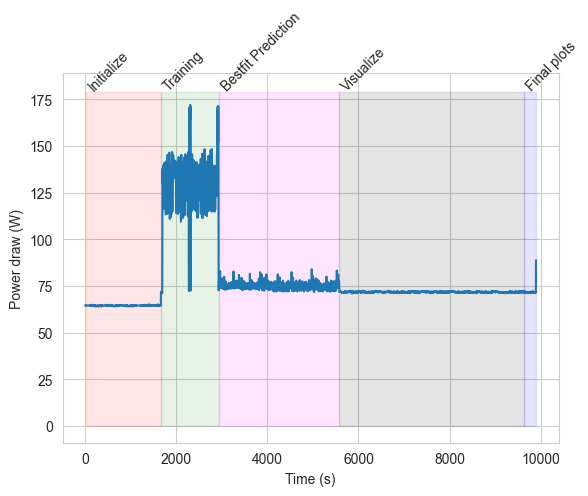

Generate output for Epoch 30


,time,timer,dt,tag
0,10.461425,total,None,TIMER1
1,10.461425,total,26757.542,TIMER2
2,25.461425,INIT,2.095,TIMER2
3,28.461425,EVAL,413.412,TIMER2
4,28.461425,PLOTS,388.651,TIMER2
...,...,...,...,...
420,26765.461425,RunTFTCustomVersion DLResults Graph Title even...,0.0,TIMER2
421,26765.461425,RunTFTCustomVersion DLResults Graph Title even...,0.0,TIMER2
422,26765.461425,RunTFTCustomVersion DLResults Graph Title even...,0.0,TIMER2
423,26765.461425,RunTFTCustomVersion DLResults Graph Title even...,0.0,TIMER2


,time,0 id,0 gpu_util %,0 memory_util %,0 encoder_util %,0 decoder_util %,0 gpu_temp C,0 power_draw W
0,0.000000,0,0,0,0,0,28,62.86
1,2.172422,0,0,0,0,0,28,62.86
2,4.195892,0,0,0,0,0,28,62.86
3,6.382399,0,0,0,0,0,28,62.86
4,8.574598,0,0,0,0,0,28,62.86
...,...,...,...,...,...,...,...,...
12312,26770.241591,0,0,0,0,0,30,70.40
12313,26772.426120,0,0,0,0,0,30,70.40
12314,26774.602164,0,0,0,0,0,30,70.68
12315,26776.784935,0,0,0,0,0,30,70.68


25.461425000001327 <class 'float'> 180 <class 'int'> INIT <class 'str'>
Initialize
1686.4614250000013 <class 'float'> 180 <class 'int'> RunTFTCustomVersion A <class 'str'>
Training
19730.461425 <class 'float'> 180 <class 'int'> RunTFTCustomVersion bestfit finalize TFTTestpredict timer_num:0 <class 'str'>
Bestfit Prediction
22337.461425 <class 'float'> 180 <class 'int'> RunTFTCustomVersion bestfit finalize VisualizeTFT timer_num:0 <class 'str'>
Visualize
26513.461425 <class 'float'> 180 <class 'int'> result <class 'str'>
Final plots
[0, 25.461425000001327, 1686.4614250000013, 19730.461425, 22337.461425, 26513.461425, 26778.975483]
[0, 180, 180, 180, 180, 180, 0]


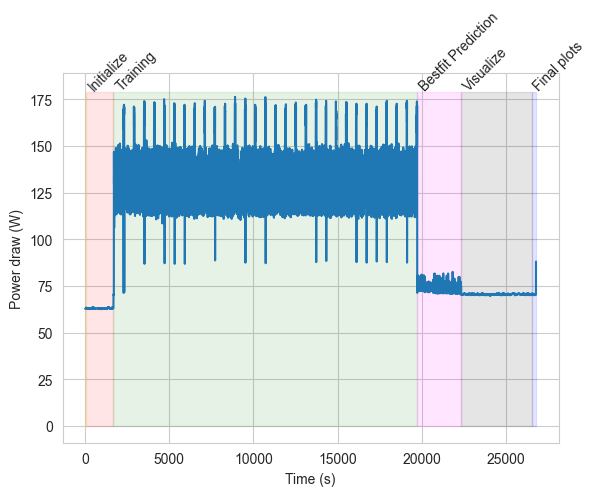

Generate output for Epoch 70


,time,timer,dt,tag
0,10.432375,total,None,TIMER1
1,10.432375,total,50441.073,TIMER2
2,25.432375,INIT,2.579,TIMER2
3,28.432375,EVAL,408.511,TIMER2
4,28.432375,PLOTS,383.499,TIMER2
...,...,...,...,...
700,50448.432375,RunTFTCustomVersion DLResults Graph Title even...,0.0,TIMER2
701,50448.432375,RunTFTCustomVersion DLResults Graph Title even...,0.0,TIMER2
702,50449.432375,RunTFTCustomVersion DLResults Graph Title even...,0.0,TIMER2
703,50449.432375,RunTFTCustomVersion DLResults Graph Title even...,0.0,TIMER2


,time,0 id,0 gpu_util %,0 memory_util %,0 encoder_util %,0 decoder_util %,0 gpu_temp C,0 power_draw W
0,0.000000,0,0,0,0,0,29,61.81
1,2.377373,0,0,0,0,0,29,61.81
2,4.745279,0,0,0,0,0,29,61.81
3,7.102939,0,0,0,0,0,29,61.81
4,9.455125,0,0,0,0,0,29,61.81
...,...,...,...,...,...,...,...,...
25104,50456.757102,0,0,0,0,0,31,68.51
25105,50458.411075,0,0,0,0,0,31,68.51
25106,50460.048054,0,0,0,0,0,31,68.51
25107,50461.685282,0,0,0,0,0,32,87.30


25.43237500000032 <class 'float'> 180 <class 'int'> INIT <class 'str'>
Initialize
1691.4323750000003 <class 'float'> 180 <class 'int'> RunTFTCustomVersion A <class 'str'>
Training
43460.432375 <class 'float'> 180 <class 'int'> RunTFTCustomVersion bestfit finalize TFTTestpredict timer_num:0 <class 'str'>
Bestfit Prediction
45980.432375 <class 'float'> 180 <class 'int'> RunTFTCustomVersion bestfit finalize VisualizeTFT timer_num:0 <class 'str'>
Visualize
50199.432375000004 <class 'float'> 180 <class 'int'> result <class 'str'>
Final plots
[0, 25.43237500000032, 1691.4323750000003, 43460.432375, 45980.432375, 50199.432375000004, 50463.553789]
[0, 180, 180, 180, 180, 180, 0]


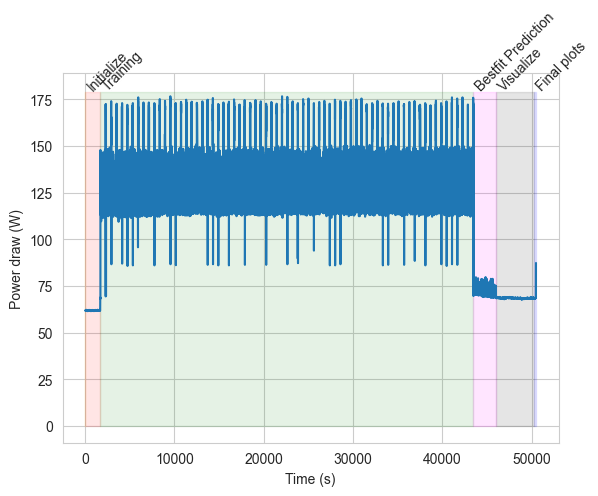

Generate output for Epoch 25


,time,timer,dt,tag
0,8.190347,total,None,NaN
1,8.190347,total,29130.287,NaN
2,10.190347,INIT,0.925,NaN
3,12.190347,EVAL,431.358,NaN
4,12.190347,PLOTS,403.874,NaN
...,...,...,...,...
385,29134.190347,RunTFTCustomVersion DLResults Graph Title even...,0.0,NaN
386,29134.190347,RunTFTCustomVersion DLResults Graph Title even...,0.0,NaN
387,29134.190347,RunTFTCustomVersion DLResults Graph Title even...,0.0,NaN
388,29134.190347,RunTFTCustomVersion DLResults Graph Title even...,0.0,NaN


,time,0 id,0 gpu_util %,0 memory_util %,0 encoder_util %,0 decoder_util %,0 gpu_temp C,0 power_draw W
0,0.000000,0,0,0,0,0,33,42.98
1,0.167135,0,0,0,0,0,33,42.98
2,0.315287,0,0,0,0,0,33,43.01
3,0.483782,0,0,0,0,0,33,42.98
4,0.670563,0,0,0,0,0,33,42.98
...,...,...,...,...,...,...,...,...
269863,29152.241489,0,0,0,0,0,38,67.73
269864,29152.335411,0,0,0,0,0,38,67.73
269865,29152.426906,0,0,0,0,0,38,67.73
269866,29152.558509,0,0,0,0,0,38,67.73


10.190346999999747 <class 'float'> 180 <class 'int'> INIT <class 'str'>
Initialize
2118.1903469999997 <class 'float'> 180 <class 'int'> RunTFTCustomVersion A <class 'str'>
Training
20642.190347000003 <class 'float'> 180 <class 'int'> RunTFTCustomVersion bestfit finalize TFTTestpredict timer_num:0 <class 'str'>
Bestfit Prediction
25268.190347000003 <class 'float'> 180 <class 'int'> RunTFTCustomVersion bestfit finalize VisualizeTFT timer_num:0 <class 'str'>
Visualize
28928.190347000003 <class 'float'> 180 <class 'int'> result <class 'str'>
Final plots
[0, 10.190346999999747, 2118.1903469999997, 20642.190347000003, 25268.190347000003, 28928.190347000003, 29152.709153]
[0, 180, 180, 180, 180, 180, 0]


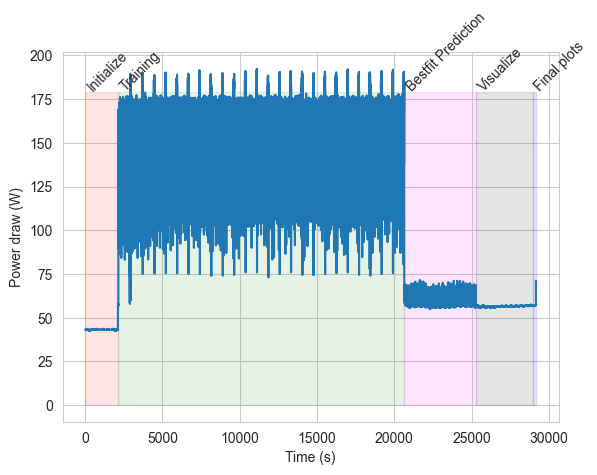

Generate output for Epoch 29


,time,timer,dt,tag
0,7.860564,total,None,NaN
1,7.860564,total,32049.984,NaN
2,10.860564,INIT,0.901,NaN
3,11.860564,EVAL,419.623,NaN
4,11.860564,PLOTS,391.929,NaN
...,...,...,...,...
413,32052.860564,RunTFTCustomVersion DLResults Graph Title even...,0.0,NaN
414,32052.860564,RunTFTCustomVersion DLResults Graph Title even...,0.0,NaN
415,32053.860564,RunTFTCustomVersion DLResults Graph Title even...,0.0,NaN
416,32053.860564,RunTFTCustomVersion DLResults Graph Title even...,0.0,NaN


,time,0 id,0 gpu_util %,0 memory_util %,0 encoder_util %,0 decoder_util %,0 gpu_temp C,0 power_draw W
0,0.000000,0,0,0,0,0,35,41.11
1,0.122557,0,0,0,0,0,34,41.11
2,0.215641,0,0,0,0,0,34,41.11
3,0.323522,0,0,0,0,0,34,41.11
4,0.454929,0,0,0,0,0,34,41.11
...,...,...,...,...,...,...,...,...
300668,32071.453504,0,0,0,0,0,37,64.50
300669,32071.559866,0,0,0,0,0,36,64.45
300670,32071.648466,0,0,0,0,0,36,64.50
300671,32071.736126,0,0,0,0,0,37,64.50


10.860563999998703 <class 'float'> 180 <class 'int'> INIT <class 'str'>
Initialize
2082.8605639999987 <class 'float'> 180 <class 'int'> RunTFTCustomVersion A <class 'str'>
Training
23635.860564000002 <class 'float'> 180 <class 'int'> RunTFTCustomVersion bestfit finalize TFTTestpredict timer_num:0 <class 'str'>
Bestfit Prediction
28342.860564000002 <class 'float'> 180 <class 'int'> RunTFTCustomVersion bestfit finalize VisualizeTFT timer_num:0 <class 'str'>
Visualize
31858.860564000002 <class 'float'> 180 <class 'int'> result <class 'str'>
Final plots
[0, 10.860563999998703, 2082.8605639999987, 23635.860564000002, 28342.860564000002, 31858.860564000002, 32071.821536]
[0, 180, 180, 180, 180, 180, 0]


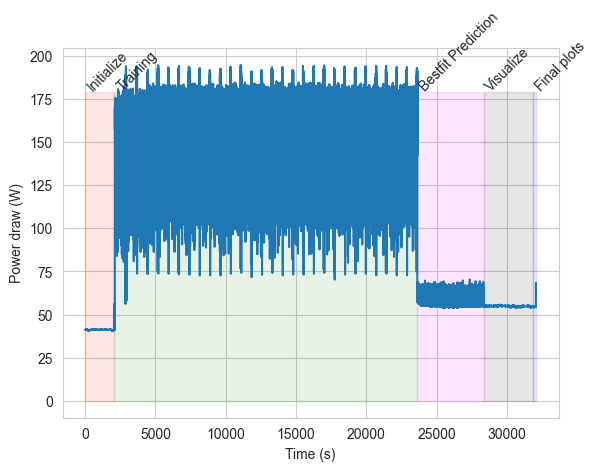

Generate output for Epoch 33


,time,timer,dt,tag
0,8.063862,total,None,NaN
1,8.063862,total,33714.366,NaN
2,11.063862,INIT,0.947,NaN
3,12.063862,EVAL,385.639,NaN
4,12.063862,PLOTS,358.143,NaN
...,...,...,...,...
441,33719.063862,RunTFTCustomVersion DLResults Graph Title even...,0.0,NaN
442,33719.063862,RunTFTCustomVersion DLResults Graph Title even...,0.0,NaN
443,33719.063862,RunTFTCustomVersion DLResults Graph Title even...,0.0,NaN
444,33719.063862,RunTFTCustomVersion DLResults Graph Title even...,0.0,NaN


,time,0 id,0 gpu_util %,0 memory_util %,0 encoder_util %,0 decoder_util %,0 gpu_temp C,0 power_draw W
0,0.000000,0,0,0,0,0,39,41.55
1,0.103800,0,0,0,0,0,39,41.55
2,0.231326,0,0,0,0,0,39,41.55
3,0.368301,0,0,0,0,0,39,41.55
4,0.498490,0,0,0,0,0,39,41.55
...,...,...,...,...,...,...,...,...
307452,33733.647768,0,0,0,0,0,43,66.36
307453,33733.773100,0,0,0,0,0,43,66.36
307454,33733.959872,0,0,0,0,0,43,66.36
307455,33734.125913,0,0,0,0,0,43,66.36


11.063861999999062 <class 'float'> 180 <class 'int'> INIT <class 'str'>
Initialize
1881.063861999999 <class 'float'> 180 <class 'int'> RunTFTCustomVersion A <class 'str'>
Training
26544.063862000003 <class 'float'> 180 <class 'int'> RunTFTCustomVersion bestfit finalize TFTTestpredict timer_num:0 <class 'str'>
Bestfit Prediction
30018.063862000003 <class 'float'> 180 <class 'int'> RunTFTCustomVersion bestfit finalize VisualizeTFT timer_num:0 <class 'str'>
Visualize
33531.063862 <class 'float'> 180 <class 'int'> result <class 'str'>
Final plots
[0, 11.063861999999062, 1881.063861999999, 26544.063862000003, 30018.063862000003, 33531.063862, 33734.228047]
[0, 180, 180, 180, 180, 180, 0]


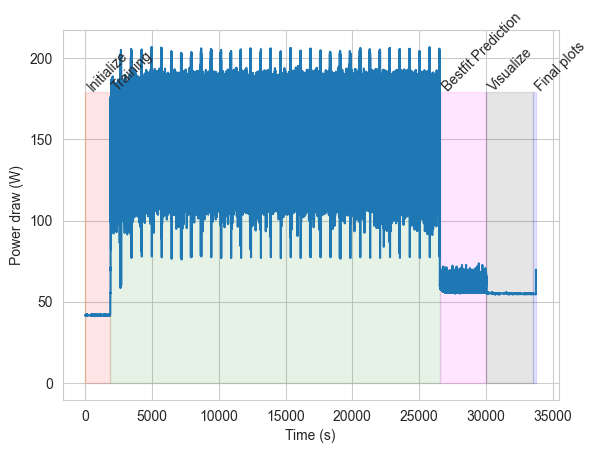

Generate output for Epoch 35


,time,timer,dt,tag
0,15.30065,total,None,NaN
1,15.30065,total,34196.647,NaN
2,18.30065,INIT,0.843,NaN
3,19.30065,EVAL,401.457,NaN
4,19.30065,PLOTS,368.758,NaN
...,...,...,...,...
455,34209.30065,RunTFTCustomVersion DLResults Graph Title even...,0.0,NaN
456,34209.30065,RunTFTCustomVersion DLResults Graph Title even...,0.0,NaN
457,34209.30065,RunTFTCustomVersion DLResults Graph Title even...,0.0,NaN
458,34209.30065,RunTFTCustomVersion DLResults Graph Title even...,0.0,NaN


,time,0 id,0 gpu_util %,0 memory_util %,0 encoder_util %,0 decoder_util %,0 gpu_temp C,0 power_draw W
0,0.000000,0,0,0,0,0,28,40.01
1,0.207386,0,0,0,0,0,28,40.03
2,0.416245,0,0,0,0,0,28,40.03
3,0.553336,0,0,0,0,0,28,40.03
4,0.739330,0,0,0,0,0,28,40.03
...,...,...,...,...,...,...,...,...
371274,34223.232555,0,0,0,0,0,30,65.70
371275,34223.417974,0,0,0,0,0,30,65.70
371276,34223.665625,0,0,0,0,0,30,65.70
371277,34223.872146,0,0,0,0,0,30,65.70


18.300650000001042 <class 'float'> 180 <class 'int'> INIT <class 'str'>
Initialize
1938.300650000001 <class 'float'> 180 <class 'int'> RunTFTCustomVersion A <class 'str'>
Training
27497.300649999997 <class 'float'> 180 <class 'int'> RunTFTCustomVersion bestfit finalize TFTTestpredict timer_num:0 <class 'str'>
Bestfit Prediction
30765.300649999997 <class 'float'> 180 <class 'int'> RunTFTCustomVersion bestfit finalize VisualizeTFT timer_num:0 <class 'str'>
Visualize
34024.30065 <class 'float'> 180 <class 'int'> result <class 'str'>
Final plots
[0, 18.300650000001042, 1938.300650000001, 27497.300649999997, 30765.300649999997, 34024.30065, 34223.957927]
[0, 180, 180, 180, 180, 180, 0]


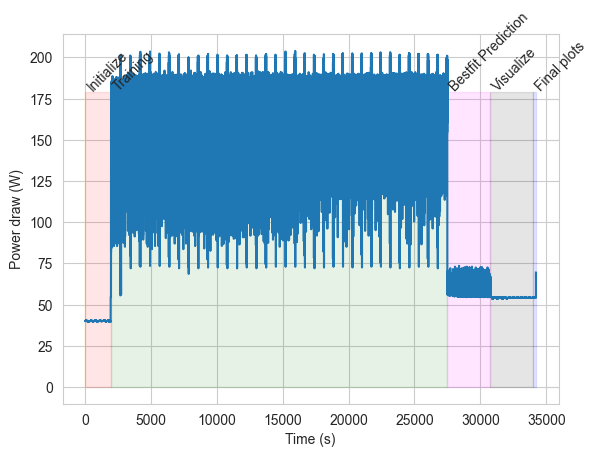

In [9]:
list_of_filenames = [('./data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_2/gpu0.log', 2),
                     ('./data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_30/gpu0.log', 30),
                     ('./data/card_name_a100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_70/gpu0.log', 70),
                     ('./data/card_name_v100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_25/gpu0.log', 25),
                     ('./data/card_name_v100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_29/gpu0.log', 29),
                     ('./data/card_name_v100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_33/gpu0.log', 33),
                     ('./data/card_name_v100_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_35/gpu0.log', 35)]
                     # ('./data/card_name_k80_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_25/gpu0.log', 25),
                     # ('./data/card_name_k80_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_29/gpu0.log', 29),
                     # ('./data/card_name_k80_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_33/gpu0.log', 33),
                     # ('./data/card_name_k80_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_35/gpu0.log', 35)]

for entry  in files:
    # 'gpulog': 'data\\card_name_k80_gpu_count_1_cpu_num_6_mem_32GB_repeat_1_TFTTransformerepochs_35\\gpu0.log'}]
    name_of_gpu = entry.gpulog.split('_gpu_count')[0].split('card_name_')[1]

    print (f"Generate output for Epoch {entry.epoch}")
    energylog = read_energy(entry.gpulog)
    eventlog = read_eventlog(entry.eventlog)

    t0_energy = energylog.time.iloc[0]
    t0_events = eventlog.time.iloc[0]

    t0 = min(t0_events, t0_energy)

    energylog["time"] = energylog["time"] - t0
    eventlog["time"] = eventlog["time"] - t0

    eventlog["time"] = eventlog["time"] / np.timedelta64(1, 's') - 5 * 60 * 60
    energylog["time"] = energylog["time"] / np.timedelta64(1, 's')

    display(eventlog)

    display(energylog)

    plot_events_and_energy(energylog, eventlog, entry.epoch)
    image_file = Shell.map_filename(f'./data/{name_of_gpu}-shaded-energy-{entry.epoch}-epochs.png').path
    plt.savefig(image_file, bbox_inches='tight')
    image_file = Shell.map_filename(f'./data/{name_of_gpu}-shaded-energy-{entry.epoch}-epochs.pdf').path
    plt.savefig(image_file, bbox_inches='tight')
    plt.show()
